# BrainPy Quickstart

**BrainPy is a lightweight framework for prototyping and building your neuronal models on computational neuroscience and brain-inspired computation.** 

Two main functions are provided in BrainPy: *dynamics simulation* and *dynamics analysis*. In this part, I will focus on neuronal dynamics simulation, and tell you how to code a dynamics network in BrainPy.

First of all, import the package.

In [1]:
import brainpy as bp

BrainPy provide a unified backend for NumPy and Numba (and further we will support JAX, TensorFlow, PyTorch). Using the same NumPy-like API, your codes can run everywhere, such as CPU, multi-core and GPU (will support in the next cycle of development). Therefore, compare to use ``import numpy as np``, we recommond you to import our unified backend as ``import brainpy.numpy as np``. 

In [2]:
import brainpy.numpy as np

In this section, I will illustrate how to use BrainPy by implementing the paper of *(Wang & Buzsáki, 1996)*.

- Wang, Xiao-Jing, and György Buzsáki. "Gamma oscillation by synaptic inhibition in a hippocampal interneuronal network model." Journal of neuroscience 16.20 (1996): 6402-6413.

*(Wang & Buzsáki, 1996)* demonstrates how a group of neuron with mutual inhibition produce the gamma oscillation (20–80 Hz) observed in the neocortex and hippocampus. In this network model, the neurons are modeled as a variant of Hodgkin–Huxley (HH) neuron model, and the inhibition connections between neurons are modeled as the GABA<sub>A</sub> synapses.

In this section, we will first build a HH neuron model. Then, construct a GABA<sub>A</sub> synapse model. Finally, combining the HH model and GABA<sub>A</sub> moldel together, we will build a network model. We expect at the suitable parameter regions, the network will produce gamma oscillation.

In BrainPy, all the system-level settings are implmented in ``bp.profile``. By using ``bp.profile``, you can set the backend or the device of the models going to run on, the method and the precision of the numerical integrator, etc. Before dive into this tutorial, let's set the necessary profiles:

In [3]:
bp.profile.set(backend='numba',
               device='cpu',
               dt=0.04,
               numerical_method='exponential')

This setting means we will compile our model on ``numba`` backend, and run our model on ``cpu`` device; the default numerical method is set to exponential euler method (``exponential``), and the numerical step is set to ``0.04``.

## How to build a neuron model?

In BrainPy, the solving of differential equations is based on numerical methods, such as Euler method, Runge–Kutta methods. Therefore, the definition of a neuron/synapse model is the definition of the *step functions* which explicitly point out how variable state at the current time point $x(t)$ is transited to the next time point $x(t+1)$.

Let's take the neuron model as an example. To build a neuron model in BrainPy is to create an instance of ``NeuType``. The instantiation of ``NeuType`` requires three items:

- *name* : The name of the neuron model (will be useful in error reporting and debugging).
- *steps*: The step function to update at each cycle of run.
- *requires*: The data required to create before the users run this neuron model.

Here, we are going to create a HH neuron model. The parameters of HH model are defined in the follows:

In [4]:
V_th = 0.  # the spike threshold
C = 1.0  # the membrane capacitance
gLeak = 0.1  # the conductance of leaky channel
ELeak = -65  # the reversal potential of the leaky channel
gNa = 35.  # the conductance of sodium channel
ENa = 55.  # the reversal potential of sodium
gK = 9.  # the conductance of potassium channel
EK = -90.  # the reversal potential of potassium
phi = 5.0  # the temperature depdendent scaling  

In this variant of HH model, three dynamical variables ($V$, $h$ and $n$) exist.

**h channel**

Specifically, the differential equation of $h$ channel is mathematically formed as:

$$
\begin{align}
{\frac {dh}{dt}} &=\alpha _{h}(V)(1-h)-\beta _{h}(V)h \\
\alpha_h(V) &= 0.07 \cdot \exp\big(-{V+58 \over 20}\big) \\
\beta_h(V) &= {1 \over 1 + \exp\big(-{V+28\over 10}\big)}
\end{align}
$$

Code this equation in BrainPy is very simple. For any ordinary differential equation 

$$
{dx \over dt} = f(x, t)
$$

you only need write down the right-hand part of the differential equations $f(x, t)$. By adding a powerfull decorator porovided by BrainPy, ``@bp.integrate``, the framework will automatically numerically integrate the defined equations. Generally, an ordinary differential equation in BrainPy can be coded as:

In [5]:
@bp.integrate
def func(x, t, other_arguments):
    # ... some computation ...
    dxdt = ...
    return dxdt

For this $h$ channel equation, you can code like this:

In [6]:
@bp.integrate
def int_h(h, t, V):
    alpha = 0.07 * np.exp(-(V + 58) / 20)
    beta = 1 / (np.exp(-0.1 * (V + 28)) + 1)
    dhdt = alpha * (1 - h) - beta * h
    return phi * dhdt

``@bp.integrate`` receives ``method`` keyword to specify the numerical method you want to choose. For example, adding ``@bp.integrate(method='rk4')`` means you integrate the decorated function by using Fouth-order Runge–Kutta method (The full list of supportted numerical integrators please see the document of [Numerical integrators](https://brainpy.readthedocs.io/en/latest/guides/numerical_integrators.html)). Otherwise, the differential function will be integrated by the system default method.

**n channel**

The differential equation of $n$ channel is mathematically formed as: 

$$
\begin{align}
{\frac {dn}{dt}} &=\alpha _{n}(V)(1-n)-\beta _{n}(V)n \\
\alpha_n(V) &= {0.01 \cdot (V+34) \over 1-\exp\big(-{V+34 \over10}\big)} \\
\beta_n(V) &= 0.125 \cdot \exp\big(-{V+44 \over 80}\big)
\end{align}
$$

Likely, this equation can be coded as:

In [7]:
@bp.integrate
def int_n(n, t, V):
    alpha = -0.01 * (V + 34) / (np.exp(-0.1 * (V + 34)) - 1)
    beta = 0.125 * np.exp(-(V + 44) / 80)
    dndt = alpha * (1 - n) - beta * n
    return phi * dndt

**Membrane potential V**

Finally, the differential equation of membrane potential $V$ is expressed as:

$$
\begin{align}
C_{m}{\frac {d V}{dt}}&=-{\bar {g}}_{\text{K}}n^{4}(V-V_{K}) - {\bar {g}}_{\text{Na}}m^{3}h(V-V_{Na}) -{\bar {g}}_{l}(V-V_{l}) + I_{syn}
\end{align}
$$

where $m$ is modeled as an instaneous channel (fast enough and substituted by its steady-state function)


$$
\begin{align}
\alpha_m(V) &= {0.1 (V+ 40) \over 1-\exp\big(-{ V+40 \over 10}\big)} \\
\beta_m(V) &= 4.0 \cdot \exp\big(-{V+65 \over 18}\big) \\
m &= {\alpha_m(V) \over \alpha_m(V) + \beta_m(V)}
\end{align}
$$

Therefore, the differential equations of $V$ is coded as:

In [8]:
@bp.integrate
def int_V(V, t, h, n, Isyn):
    m_alpha = -0.1 * (V + 35) / (np.exp(-0.1 * (V + 35)) - 1)
    m_beta = 4 * np.exp(-(V + 60) / 18)
    m = m_alpha / (m_alpha + m_beta)
    INa = gNa * m ** 3 * h * (V - ENa)
    IK = gK * n ** 4 * (V - EK)
    IL = gLeak * (V - ELeak)
    dvdt = (- INa - IK - IL + Isyn) / C
    return dvdt

**Define state**

In order to support the convenient state management, BrainPy provides ``NeuState`` to help you manage your model state. In HH neuron, there are $V$, $h$ and $n$ dynamical variables. Moreover, the *input* of the neuron is time-variant. We can add a ``input`` item in HH neuron state to receive the varying input. Further, the neuron *spike* is also we take care of. So, the neuron state of HH model can be specified as

In [9]:
HH_ST = bp.types.NeuState({
    'V': -55.,  # membrane potential, default initial value is -55.
    'h': 0.,  # h channel, default initial value is 0.
    'n': 0.,  # n channel, default initial value is 0.
    'spike': 0.,  # neuron spike state, default initial value is 0., 
                  # if neuron emits a spike, it will be 1.
    'input': 0.  # neuron synaptic input, default initial value is 0.
})

The instantiation of ``bp.types.NeuState`` can receive a dict (which means the fields and their default initial values), or a list/tuple of fields (in this case the default initial value will be set to 0.).

**Define step functions**

In [10]:
def update(ST, _t_):
    h = int_h(ST['h'], _t_, ST['V'])
    n = int_n(ST['n'], _t_, ST['V'])
    V = int_V(ST['V'], _t_, ST['h'], ST['n'], ST['input'])
    sp = np.logical_and(ST['V'] < V_th, V >= V_th)
    ST['spike'] = sp
    ST['V'] = V
    ST['h'] = h
    ST['n'] = n
    ST['input'] = 0.

The definition of HH model update function requires two arguments: 

- ``ST``: the neuron state
- ``_t_``: the current time.

At each transition step, function ``update`` utilizes ``ST`` at the last time to acquire ``ST`` at the current time. ``_t_`` is a system keyword, which denotes the current time point. In BrainPy, there are three system keywords: ``_t_``, ``_i_`` (the current running step number), and ``_dt_`` (the numerical integration step).

The order of the arguments in each step function can be arbitrary. BrainPy will automatically pass the required data into your defined functions.

**Define a NeuType**

Finally, putting the above together, we get our HH neuron model as:

In [11]:
HH = bp.NeuType(name='HH_neuron', 
                requires={"ST": HH_ST}, 
                steps=update)

## How to build a synapse model?

First of all, let's announce the parameter all we need in the follows:

In [12]:
g_max = 0.1  # the maximal synaptic conductance
E = -75.  # the reversal potential
alpha = 12.  # the channel opening rate
beta = 0.1  # the channel closing rate

**Synaptic connectivity**

Different from the construction of the neuron model, the definition of the synapse model should consider the conncection structure between two neuron groups. 

Suppose two neuron groups (each group is expanded to 1D array and each neuron is assign to a unique index) are connected by the following structures:

<img src="../images/syn-example-pre_ids-post_ids.png" width="800 px">

In BrainPy, all synaptic connections are expanded to one-dimensional vectors. Want to know why do we design synapses like this structure, please see the document of [Explore the connectivity for efficient synapse computation]().

Then, we define the connection structure of ``pre2syn`` and ``post2syn`` like the follows: 

<img src="../images/syn-example-pre2syn.png" width="200 px" align="left">

<img src="../images/syn-example-post2syn.png" width="200 px" align="left">

``pre2syn`` is a reference between pre-synaptic neurons and the connected synaptic positions. It is a list of synaptic index arraies. This means that ``pre2syn[0]`` get the synapse computing nodes (in the above example, ``pre2syn[0] = [0, 1, 2]``) connected with the pre-synaptic neuron ``0``. Likely, ``post2syn`` get the mapping between the post-synaptic neurons and the connected synapse nodes. In the above example, ``post2syn[0] = [3]``.

**Define a SynType**

After get the synaptic structure betweem two neuron groups, let's start to define the inner logic of the synaptic computation.

The GABA<sub>A</sub> synapse defined in *(Wang & Buzsáki, 1996)* is mathematically expressed as 

$$
\begin{align}
\frac{ds}{dt} &= \alpha F(V_{pre})(1-s)-\beta s \\
F(V_{pre}) &= {1 \over 1+\exp\left(-{V_{pre}- V_{th} \over 2}\right)}
\end{align}
$$

The synaptic current output onto the post-synaptic neuron is expressed as

$$
I_{ syn }=g_{max} s\left(V-E\right)
$$

The running of the GABA<sub>A</sub> synapse requires the following data:

- ``ST``: The synaptic state, where ``g`` is the conductance onto the post-synaptic neurons, ``s`` is the synaptic channel state, and ``pre_above_th`` is the function result of $F(V_{pre})$.
- ``pre``: The pre-synaptic neuron state, in which the field ``V`` is needed to compute the synapatic state.
- ``post``: The post-synaptic neuron state, in which the fields ``V`` and ``input`` are needed.
- ``pre2syn``: The `pre2syn` connectivity structure.
- ``post2syn``: The `post2syn` connectivity structure.

In [13]:
requires = dict(
    ST=bp.types.SynState(['g', 's', 'pre_above_th']),
    pre=bp.types.NeuState(['V']),
    post=bp.types.NeuState(['V', 'input']),
    pre2syn=bp.types.ListConn(),
    post2syn=bp.types.ListConn(),
)

The state updating of GABA<sub>A</sub> synapse is based on the differential equation ``ds/dt``. The real-time conductance onto the post-synaptic neurons is computed as ``ST['g'] = g_max * s``. Thus, the overall step function about GABA<sub>A</sub> state update is coded as: 

In [14]:
@bp.integrate
def int_s(s, t, TT):
    return alpha * TT * (1 - s) - beta * s

def update(ST, _t_, pre, pre2syn):
    for pre_id, syn_ids in enumerate(pre2syn):
        ST['pre_above_th'][syn_ids] = pre['V'][pre_id] - V_th
    T = 1 / (1 + np.exp(-ST['pre_above_th'] / 2))
    s = int_s(ST['s'], _t_, T)
    ST['s'] = s
    ST['g'] = g_max * s

Moreover, at each time step, GABA<sub>A</sub> synpase will output the synaptic value onto the post-synaptic neurons. The corresponding step function is coded as:

In [15]:
def output(ST, post, post2syn):
    post_cond = np.empty(len(post2syn), dtype=np.float_)
    for post_id, syn_ids in enumerate(post2syn):
        post_cond[post_id] = np.sum(ST['g'][syn_ids])
    post['input'] -= post_cond * (post['V'] - E)

Finally, let's put the above difinition above together, and we get our wantted synapse model:

In [16]:
GABAa = bp.SynType('GABAa', requires=requires, steps=(update, output))

## How to construct a network?

It is worthy to note that the above defined ``HH`` NeuType and ``GABAa`` SynType are abstract models. They can not be used for concrete computation. Instead, we should define the ``NeuGroup`` and ``SynConn``. 

Here, by using ``bp.NeuGroup``, let's define a neuron group which contains 100 neurons. At the same time, we monitor the history trajectory of membrane potential ``V`` and spikes ``spike``.

In [17]:
num = 100
neu = bp.NeuGroup(HH, geometry=num, monitors=['spike', 'V'])

The initial state values of neurons in the group can be updated by set ``neu_group.ST[key] = value``.

In [18]:
v_init = -70. + np.random.random(num) * 20
h_alpha = 0.07 * np.exp(-(v_init + 58) / 20)
h_beta = 1 / (np.exp(-0.1 * (v_init + 28)) + 1)
h_init = h_alpha / (h_alpha + h_beta)
n_alpha = -0.01 * (v_init + 34) / (np.exp(-0.1 * (v_init + 34)) - 1)
n_beta = 0.125 * np.exp(-(v_init + 44) / 80)
n_init = n_alpha / (n_alpha + n_beta)

neu.ST['V'] = v_init
neu.ST['h'] = h_init
neu.ST['n'] = n_init

Similarly, the concrete synaptic connection can be constructed by using ``bp.SynConn``. It receives an instance of SynType (argument ``model``), the pre-synaptic neuron group (argument ``pre_group``), the post-synaptic neuron group (argument ``post_group``), and connection methods between the two groups (argument ``conn``).

In [19]:
syn = bp.SynConn(model=GABAa, 
                 pre_group=neu, 
                 post_group=neu,
                 conn=bp.connect.All2All(include_self=False),
                 monitors=['s', 'g'])

The parameters of the created synapse connection can be updated by using ``syn_conn.pars[key] = value``.

In [20]:
syn.pars['g_max'] = 0.1 / num

Finally, by adding the created neuron groups and synapse connection into the ``bp.Network``, we get an instance of the network. Each ``bp.Network`` has a powerful function ``.run()``. You can specify the total duration to run (argument ``duration``), the inputs to various components (argument ``inputs``), and the option for progress reporting (arguments ``report`` and ``report_percent``). 

In [21]:
net = bp.Network(neu, syn)
net.run(duration=500., inputs=[neu, 'ST.input', 1.2], report=True, report_percent=0.2)

Compilation used 4.0593 ms.
Start running ...
Run 20.0% used 0.384 s.
Run 40.0% used 0.760 s.
Run 60.0% used 1.136 s.
Run 80.0% used 1.512 s.
Run 100.0% used 1.888 s.
Simulation is done in 1.888 s.


Let's visualize the network running results.

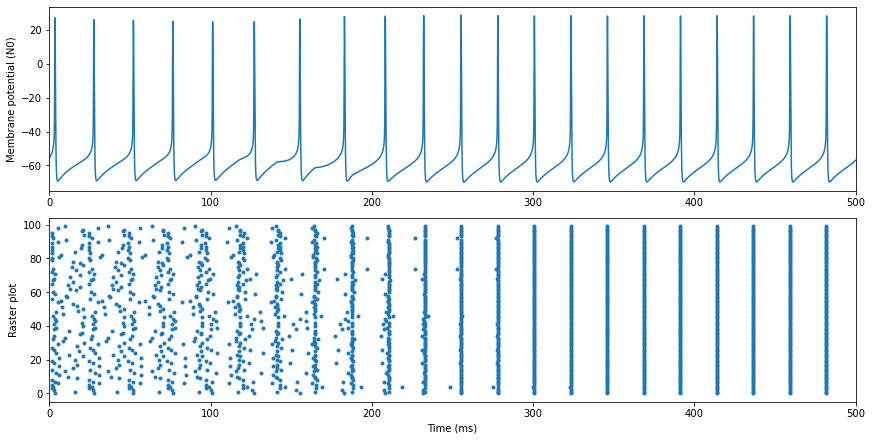

In [22]:
import matplotlib.pyplot as plt

ts = net.ts
fig, gs = bp.visualize.get_figure(2, 1, 3, 12)

fig.add_subplot(gs[0, 0])
plt.plot(ts, neu.mon.V[:, 0])
plt.ylabel('Membrane potential (N0)')
plt.xlim(net.t_start - 0.1, net.t_end + 0.1)

fig.add_subplot(gs[1, 0])
index, time = bp.measure.raster_plot(neu.mon.spike, net.ts)
plt.plot(time, index, '.')
plt.xlim(net.t_start - 0.1, net.t_end + 0.1)
plt.xlabel('Time (ms)')
plt.ylabel('Raster plot')

plt.show()

The full file of this example model can be obtained in [gamma_oscillation.py](https://github.com/PKU-NIP-Lab/BrainPy/blob/master/examples/networks/gamma_oscillation.py).